In [17]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

sns.set_palette('PiYG')

In [18]:
df = pd.read_excel("students_internet_performance.xlsx")
df.head() #проеверка на адекватность

,Unnamed: 0,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,...,goout,health,failures_PORTUGESE,paid_PORTUGESE,absences_PORTUGESE,finalGrade_PORTUGESE,failures_MATH,paid_MATH,absences_MATH,finalGrade_MATH
0,0,GP,F,18,U,GT3,A,4,4,at_home,...,4,3,0,no,4,11,0,no,6,6
1,1,GP,F,17,U,GT3,T,1,1,at_home,...,3,3,0,no,2,11,0,no,4,6
2,2,GP,F,15,U,LE3,T,1,1,at_home,...,2,3,0,no,6,12,3,yes,10,10
3,3,GP,F,15,U,GT3,T,4,2,health,...,2,5,0,no,0,14,0,yes,2,15
4,4,GP,F,16,U,GT3,T,3,3,other,...,2,5,0,no,0,13,0,yes,4,10


In [19]:
df.shape

(370, 32)

In [20]:
#df.info()

In [21]:
df.columns

Index(['Unnamed: 0', 'school', 'sex', 'age', 'address', 'famsize', 'Pstatus',
       'Medu', 'Fedu', 'Mjob', 'Fjob', 'reason', 'studytime', 'schoolsup',
       'famsup', 'activities', 'nursery', 'higher', 'internet', 'romantic',
       'famrel', 'freetime', 'goout', 'health', 'failures_PORTUGESE',
       'paid_PORTUGESE', 'absences_PORTUGESE', 'finalGrade_PORTUGESE',
       'failures_MATH', 'paid_MATH', 'absences_MATH', 'finalGrade_MATH'],
      dtype='object')

In [22]:
df = pd.get_dummies(df, columns = ['Mjob', 'Fjob', 'reason']).astype('int64')
df.columns

ValueError: invalid literal for int() with base 10: 'GP'

In [ ]:
#df.info()

In [ ]:
df_continuous = df[['age','absences_PORTUGESE','absences_MATH','finalGrade_PORTUGESE','finalGrade_MATH']]
df_ordinal = df[['Medu', 'Fedu', 'studytime', 'famrel', 'freetime', 'goout', 'health', 'failures_PORTUGESE', 'failures_MATH']]
df_dummy = df[['school', 'sex', 'address', 'famsize', 'Pstatus', 'schoolsup', 'famsup', 'activities', 'nursery', 'higher',
               'internet', 'romantic', 'paid_PORTUGESE', 'paid_MATH', 'Mjob_at_home', 'Mjob_health', 'Mjob_other',
               'Mjob_services', 'Mjob_teacher', 'Fjob_at_home', 'Fjob_health',
               'Fjob_other', 'Fjob_services', 'Fjob_teacher', 'reason_course',
               'reason_home', 'reason_other', 'reason_reputation']]

# Первичный анализ

In [ ]:
df_continuous.describe().T.round(2)

In [ ]:
df_ordinal.describe().T.round(2)

In [ ]:
df.nunique()

In [ ]:
df_continuous.hist(grid=False, bins=50, figsize=(20,15))
plt.show()

Распределения далеки от нормальных, будут особенности в методах

In [ ]:
df_ordinal.hist(grid=False, bins=15, figsize=(20,15))
plt.show()

In [ ]:
df_dummy.hist(grid=False, bins=5, figsize=(20,15))
plt.show()

Эти гистограммы созданы для понимания долей, не более

# Выбросы

In [ ]:
plt.figure(figsize=(15,8))
df_continuous.boxplot(color='b',sym='r+')
plt.xticks(rotation=45)
plt.show()

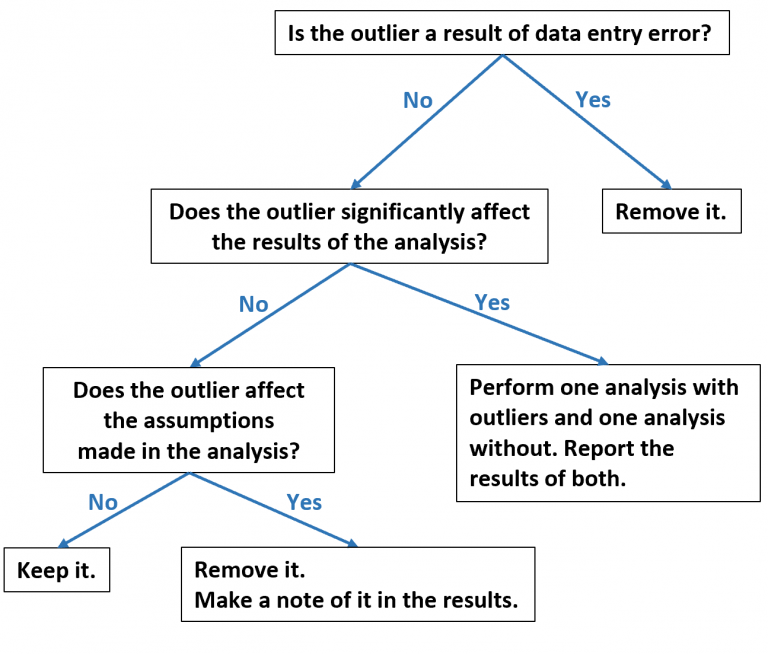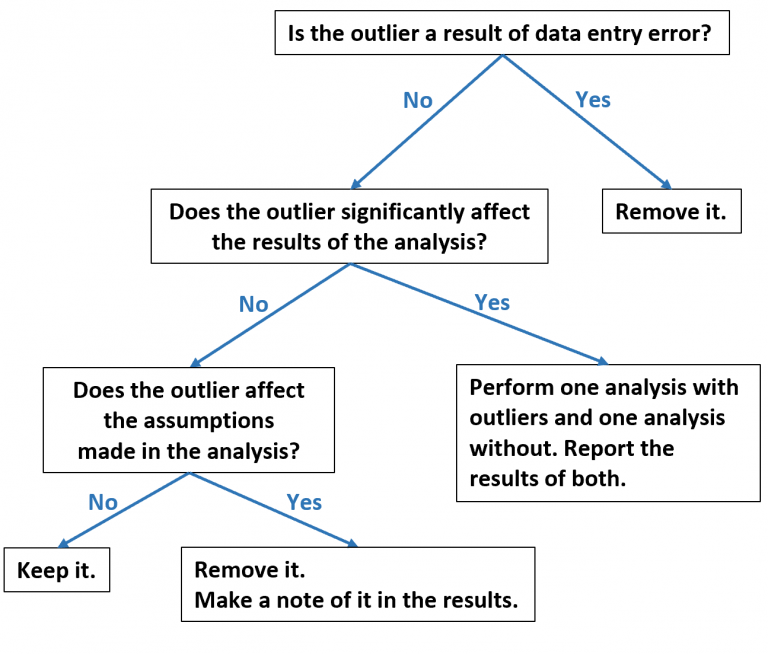

Может быть исключу выбросы в прогулах, оценки и возраст трогать не буду.

# Корреляция (проверка на мультиколлениарность)

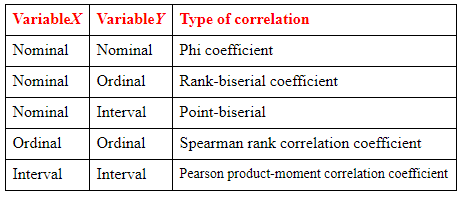

In [ ]:
sns.heatmap(df_continuous.corr(method='pearson'), cmap="PiYG", annot=True, fmt='.2f', vmin=-1, vmax=1)

https://statstutor.ac.uk/resources/uploaded/spearmans.pdf

In [ ]:
sns.heatmap(df_continuous.corr(method='spearman'), cmap="PiYG", annot=True, fmt='.2f', vmin=-1, vmax=1)

In [ ]:
sns.heatmap(df_ordinal.corr(method='spearman'), cmap="PiYG", annot=True, fmt='.2f', vmin=-1, vmax=1)

In [ ]:
sns.heatmap(df_ordinal.corr(method='kendall'), cmap="PiYG", annot=True, fmt='.2f', vmin=-1, vmax=1)

In [ ]:
def cramers_v(x, y):
    """Calculate Cramer's V statistic for categorial-categorial association."""
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

def create_cramers_v_matrix(data):
    """Create a Cramer's V matrix for a DataFrame of categorical variables."""
    cols = data.columns
    corr_matrix = pd.DataFrame(np.zeros((len(cols), len(cols))), columns=cols, index=cols)
    for col1 in cols:
        for col2 in cols:
            corr_matrix.loc[col1, col2] = cramers_v(data[col1], data[col2])
    return corr_matrix

data = df_dummy

# Calculate Cramer's V matrix
cramers_v_matrix = create_cramers_v_matrix(data)

# Plotting the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cramers_v_matrix, annot=False, fmt=".2f", vmin=-1, vmax=1, cmap='PiYG')
plt.title('Cramer\'s V Correlation Matrix')
plt.show()

Можно еще посчитать VIF (коэффициент инфляции дисперсии), граничное значение 5 или 10.

# Коэффициент инфляции дисперсии

In [ ]:
# vif для всех заданных переменных
def compute_vif(considered_features):
    
    X = df[considered_features]
    # дабавляем константу
    X['intercept'] = 1
    
    # создаем таблицу для vif
    vif = pd.DataFrame()
    vif["Variable"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif = vif[vif['Variable']!='intercept']
    return vif

considered_features = ['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu',
                       'studytime', 'schoolsup', 'famsup',
                       'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel',
                       'freetime', 'goout', 'health', 'failures_PORTUGESE', 'paid_PORTUGESE', 'absences_PORTUGESE']

compute_vif(considered_features).sort_values('VIF', ascending=False).head()

#                   'Mjob_at_home', 'Mjob_health', 'Mjob_other',
#                   'Mjob_services', 'Mjob_teacher', 'Fjob_at_home', 'Fjob_health',
#                   'Fjob_other', 'Fjob_services', 'Fjob_teacher', 'reason_course',
#                   'reason_home', 'reason_other', 'reason_reputation'

In [ ]:
considered_features = ['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu',
                       'studytime', 'schoolsup', 'famsup',
                       'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel',
                       'freetime', 'goout', 'health', 'failures_MATH', 'paid_MATH', 'absences_MATH']

compute_vif(considered_features).sort_values('VIF', ascending=False).head()

Итог: мультиколлинеарности не наблюдается

# Определение связи независимых переменных с зависимой

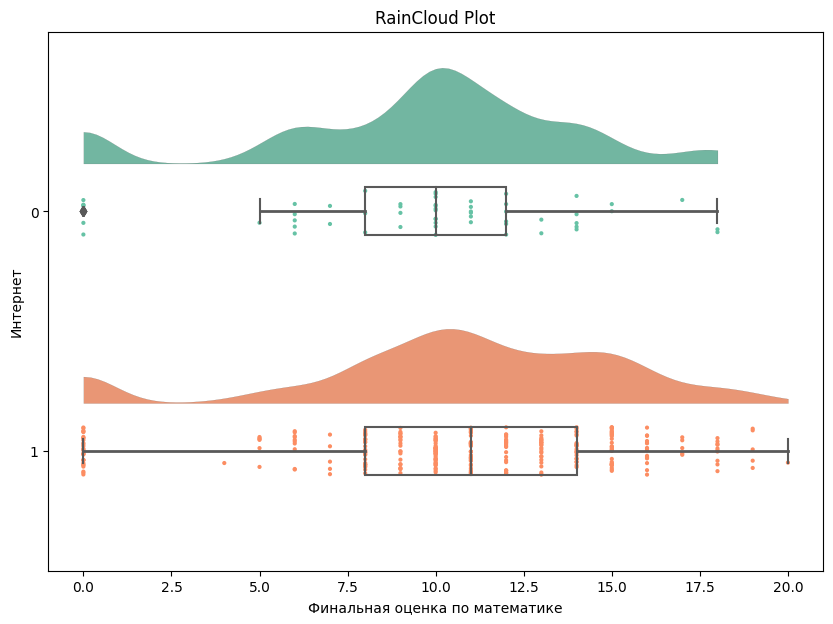

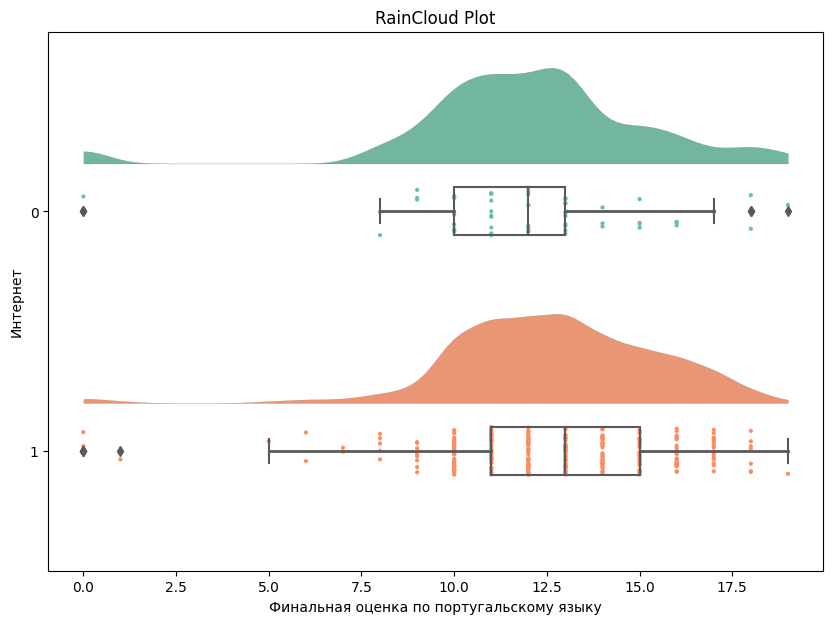

In [ ]:
figsize = (7, 4 * len(df['internet'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(df, x='internet', y='finalGrade_PORTUGESE', inner='stick', palette='PiYG')
sns.despine(top=True, right=True, bottom=True, left=True)

In [ ]:
figsize = (7, 4 * len(df['internet'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(df, x='internet', y='finalGrade_MATH', inner='stick', palette='PiYG')
sns.despine(top=True, right=True, bottom=True, left=True)

In [ ]:
corr_matrix = df.corr()
corr_matrix["finalGrade_PORTUGESE"].sort_values(ascending=False)

# ANOVA

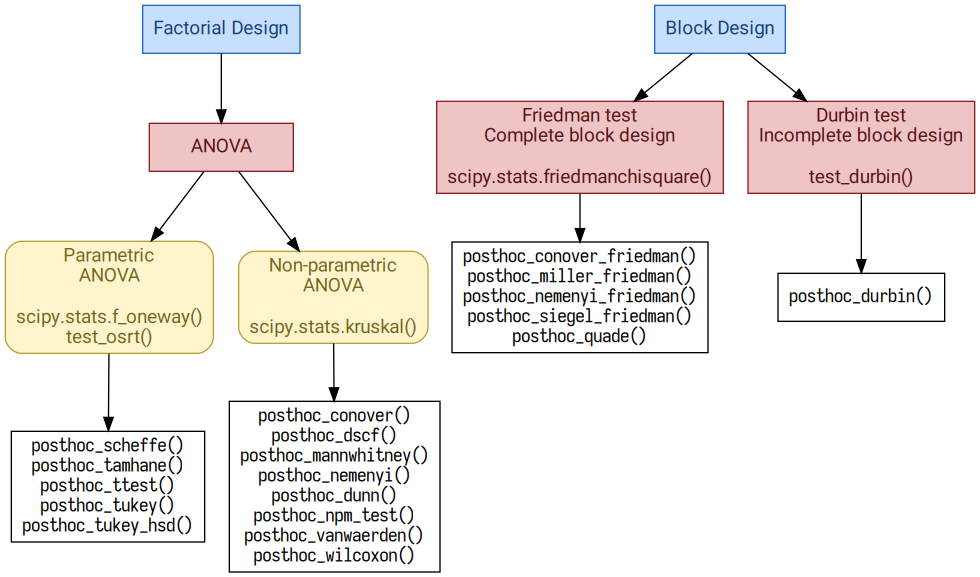

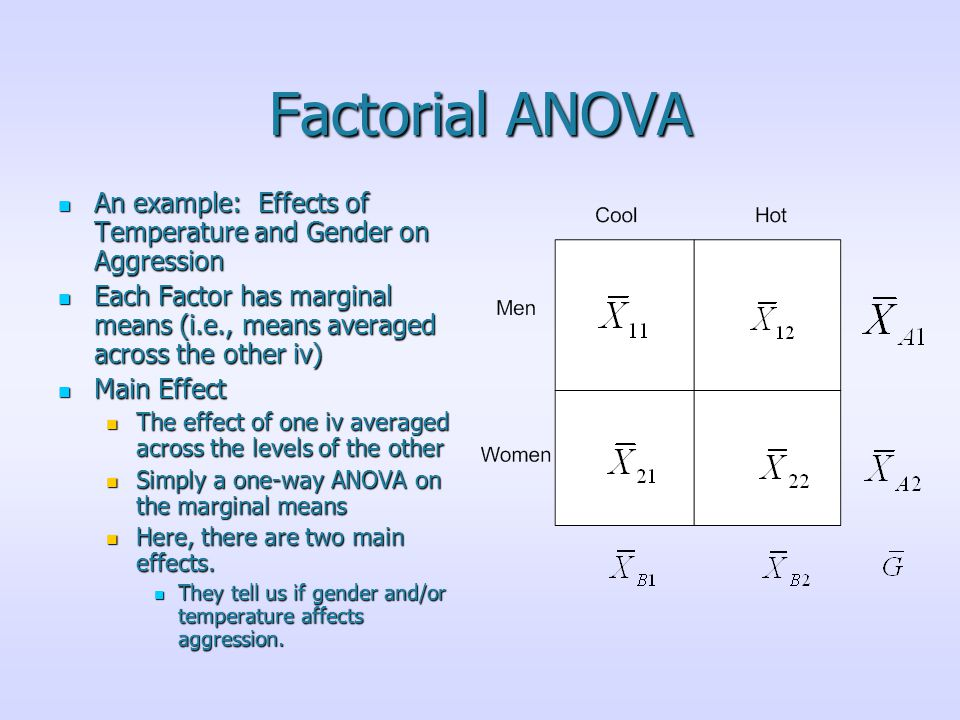

In [ ]:
from scipy.stats import f_oneway
import statsmodels.api as sa
import statsmodels.formula.api as sfa
import scikit_posthocs as sp
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [ ]:
## Португальский

In [ ]:
f_oneway(df['finalGrade_PORTUGESE'],df['internet'])

Какое-то слишком большое значение у F-statistics. Вероятно из-за выбросов. Но они не то чтобы ярко выражены, хз.

In [ ]:
lm = sfa.ols('finalGrade_PORTUGESE ~ C(internet)', data=df).fit()
anova = sa.stats.anova_lm(lm)
print(anova)

In [ ]:
f_oneway(df['finalGrade_PORTUGESE'],df['address'])

In [ ]:
lm = sfa.ols('finalGrade_PORTUGESE ~ C(address)', data=df).fit()
anova = sa.stats.anova_lm(lm)
print(anova)

In [ ]:
## Математика

In [ ]:
f_oneway(df['finalGrade_MATH'],df['internet'])

In [ ]:
lm = sfa.ols('finalGrade_MATH ~ C(internet)', data=df).fit()
anova = sa.stats.anova_lm(lm)
print(anova)

In [ ]:
f_oneway(df['finalGrade_MATH'],df['address'])

In [ ]:
lm = sfa.ols('finalGrade_MATH ~ C(address)', data=df).fit()
anova = sa.stats.anova_lm(lm)
print(anova)

Можно говорить об отвержении нулевой гипотезы (H0: равенство средних значений) для адреса. С интернетом сложнее.

Можно еще и two-way анову прогнать для двух факторов.

In [ ]:
#perform two-way ANOVA
model = ols('finalGrade_PORTUGESE ~ C(internet) + C(address) + C(internet):C(address)', data=df).fit()
sm.stats.anova_lm(model, typ=2)

Интернет как будто бы не значим

In [ ]:
#perform two-way ANOVA
model = ols('finalGrade_MATH ~ C(internet) + C(address) + C(internet):C(address)', data=df).fit()
sm.stats.anova_lm(model, typ=2)

Здесь ничего не значимо :)

# Выбор модели

Выбор по-тупому:
* Recursive Feature Elimination (RFE) is based on the idea to repeatedly construct a model and choose either the best or worst performing feature, setting the feature aside and then repeating the process with the rest of the features. This process is applied until all features in the dataset are exhausted. The goal of RFE is to select features by recursively considering smaller and smaller sets of features.

In [ ]:
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
from sklearn import preprocessing, svm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

In [ ]:
df.shape

## Что-то типо оверфита, модель носит вспомогательный характер

In [ ]:
import statsmodels.api as sm

X = df[['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu',
       'studytime', 'schoolsup', 'famsup', 'activities', 'nursery', 'higher',
       'internet', 'romantic', 'famrel', 'freetime', 'goout', 'health',
       'failures_PORTUGESE', 'paid_PORTUGESE', 'absences_PORTUGESE',
       'failures_MATH', 'paid_MATH', 'absences_MATH',
       'finalGrade_MATH', 'Mjob_at_home', 'Mjob_health', 'Mjob_other',
       'Mjob_services', 'Mjob_teacher', 'Fjob_at_home', 'Fjob_health',
       'Fjob_other', 'Fjob_services', 'Fjob_teacher', 'reason_course',
       'reason_home', 'reason_other', 'reason_reputation']]
y =df[['finalGrade_PORTUGESE']]

# Adding a constant for the intercept
X = sm.add_constant(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Fit the model using statsmodels
model = sm.OLS(y_train, X_train).fit(cov_type='HC1')

# Display the summary
print(model.summary())

## Выбор переменных исходя из предполагаемой значимости

In [ ]:
X = df[['absences_PORTUGESE','failures_PORTUGESE','finalGrade_MATH','Fjob_teacher','higher','studytime','schoolsup','sex','internet']]
y =df[['finalGrade_PORTUGESE']]

# Adding a constant for the intercept
X = sm.add_constant(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Fit the model using statsmodels
model = sm.OLS(y_train, X_train).fit(cov_type='HC1')

# Display the summary
print(model.summary())

In [ ]:
X = df[['absences_MATH','failures_MATH','finalGrade_PORTUGESE','Fjob_teacher','higher','studytime','schoolsup','sex','internet']]
y =df[['finalGrade_MATH']]

# Adding a constant for the intercept
X = sm.add_constant(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Fit the model using statsmodels
model = sm.OLS(y_train, X_train).fit(cov_type='HC1')

# Display the summary
print(model.summary())

## От одного ко многим: Математика

In [ ]:
X = df[['internet']]
y =df[['finalGrade_MATH']]

# Adding a constant for the intercept
X = sm.add_constant(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Fit the model using statsmodels
model = sm.OLS(y_train, X_train).fit(cov_type='HC1')

# Display the summary
print(model.summary())

Может быть из-за
* Confounding variabe: https://www.statology.org/confounding-variable/
* Поэтому боремся с omitted variable bias

In [ ]:
X = df[['absences_MATH','internet']]
y =df[['finalGrade_MATH']]

# Adding a constant for the intercept
X = sm.add_constant(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Fit the model using statsmodels
model = sm.OLS(y_train, X_train).fit(cov_type='HC1')

# Display the summary
print(model.summary())

*подбирала всякое разное, не очень успешно*

## От одного ко многим: Португальский

In [ ]:
X = df[['internet']]
y =df[['finalGrade_PORTUGESE']]

# Adding a constant for the intercept
X = sm.add_constant(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Fit the model using statsmodels
model = sm.OLS(y_train, X_train).fit(cov_type='HC1')

# Display the summary
print(model.summary())

In [ ]:
X = df[['sex','internet']]
y =df[['finalGrade_PORTUGESE']]

# Adding a constant for the intercept
X = sm.add_constant(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Fit the model using statsmodels
model = sm.OLS(y_train, X_train).fit(cov_type='HC1')

# Display the summary
print(model.summary())

In [ ]:
X = df[['studytime','sex','internet']]
y =df[['finalGrade_PORTUGESE']]

# Adding a constant for the intercept
X = sm.add_constant(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Fit the model using statsmodels
model = sm.OLS(y_train, X_train).fit(cov_type='HC1')

# Display the summary
print(model.summary())

In [ ]:
X = df[['finalGrade_MATH','studytime','sex','internet']]
y =df[['finalGrade_PORTUGESE']]

# Adding a constant for the intercept
X = sm.add_constant(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Fit the model using statsmodels
model = sm.OLS(y_train, X_train).fit(cov_type='HC1')

# Display the summary
print(model.summary())

In [ ]:
# Можно попробовать без кроссвалидации
# Либо сказать, что переменная не значима и объяснить почему

In [ ]:
# Тут тесты на нормальность остатков, Уайт, Бреуш-Пааган